In [1]:
import pandas as pd
from pathlib import Path
import email
import numpy as np
import string
import re

!wget https://bailando.berkeley.edu/enron/enron_with_categories.tar.gz

# Data Prepration

In [2]:
data_location = './enron_with_categories'

In [3]:
# Read txt and cats file and map them based on file id.
#extract relavent classification tag for email content
data_folder = Path(data_location)
files = data_folder.glob('./*/*.txt')
data = [(i.name.split('.')[0], i.read_text()) for i in files]
data_frame = pd.DataFrame(data, columns = ['file_id','content'])
category_tags_files = data_folder.glob('./*/*.cats')
data_cat = [(i.name.split('.')[0], i.read_text().split('\n')[0]) for i in category_tags_files]
tag_dataframe = pd.DataFrame(data_cat, columns =['file_id','category_tag'])
email_dataframe = data_frame.set_index('file_id').join(tag_dataframe.set_index('file_id'))
email_dataframe['category_tag'] = email_dataframe['category_tag'].astype('str')
email_dataframe['category_tag'] = email_dataframe['category_tag'].apply(lambda x: int(x.split(',')[1].strip()) if x.split(',')[0].strip() == '1' else np.NaN)
email_dataframe['category_tag'] = email_dataframe['category_tag'].astype('int')
email_dataframe.reset_index(inplace=True)

In [4]:
def get_content_from_email(email_content):
    '''get the content from email objects'''
    parts = []
    for sub_part in email_content.walk():
        if sub_part.get_content_type() == 'text/plain':
            payload = sub_part.get_payload()
            payload = ' '.join(payload.split())
            parts.append( payload )
        subject = email_content.get('Subject')
        
    return ''.join(parts), subject

In [5]:
#extract email text using helper function and dedupe
# remove last two categories for empty message
messages = list(map(email.message_from_string, email_dataframe['content']))
email_dataframe[['email_text','subject']] = list(map(get_content_from_email, messages))
email_dataframe['text'] = email_dataframe['subject'] + ". " + email_dataframe['email_text']
email_dataframe['text'] = email_dataframe['text'].apply(lambda x: x.lstrip(' .'))
email_dataframe.drop(columns=['email_text'], inplace=True)
email_dataframe.rename(columns={'text': 'email_text'}, inplace=True)
email_dataframe.drop(index = email_dataframe.query("category_tag == 7 or category_tag == 8").index, inplace=True)

In [6]:
def remove_forward_mail_text(text_or):
#     text = text.split('Forwarded by')[0].strip()
    text = re.split(f'[.]+[^.]+[{string.punctuation}]+\s*Forwarded\s+by', text_or)
#     if len(text) > 1:
#         print(f'Original text \n {text_or} \n split text \n {text[0]}\n')
    return text[0]

In [7]:
import string
def remove_extra_space(text):
    # lowercasing all the words
    text = text.lower()
    
    # remove extra new lines
    text = re.sub(r'\n+', ' ', text)
      
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [8]:
#remove forwarded message text
#remove extra spae
# re move stop word
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
email_dataframe['email_text'] = email_dataframe['email_text'].apply(lambda x : remove_forward_mail_text(x))
email_dataframe['email_text'] = email_dataframe['email_text'].apply(lambda x : remove_extra_space(x))
email_dataframe['email_text'] = email_dataframe['email_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
category_name_to_tag = {
    "Company Business, Strategy, etc.": 1,
    "Purely Personal": 2,
    "Personal but in professional context": 3,
    "Logistic Arrangements": 4,
    "Employment arrangements": 5,
    "Document editing/checking": 6  
}
category_tag_to_name = {v:k for k,v in category_name_to_tag.items()}

In [10]:
#map category_tags to corresponding category name
email_dataframe['category_name'] = email_dataframe['category_tag'].apply(lambda x: category_tag_to_name[x])
email_dataframe['category_tag'] = email_dataframe['category_tag'] -1
email_dataframe = email_dataframe[['file_id','content','email_text','category_tag','category_name']]
email_dataframe.head(10)

,file_id,content,email_text,category_tag,category_name
0,10425,Message-ID: <197504.1075840201539.JavaMail.eva...,translation articles,0,"Company Business, Strategy, etc."
1,106296,Message-ID: <11991339.1075842536086.JavaMail.e...,tw gas sales: privileged confidential attorney...,0,"Company Business, Strategy, etc."
2,106298,Message-ID: <7106753.1075842536132.JavaMail.ev...,tw gas sales: privileged confidential attorney...,0,"Company Business, Strategy, etc."
3,106588,Message-ID: <21267718.1075863331587.JavaMail.e...,tw gas sales: privileged confidential attorney...,0,"Company Business, Strategy, etc."
4,106590,Message-ID: <20866019.1075863331634.JavaMail.e...,tw gas sales: privileged confidential attorney...,0,"Company Business, Strategy, etc."
5,109359,Message-ID: <3018764.1075842766409.JavaMail.ev...,confidential information securities trading. t...,0,"Company Business, Strategy, etc."
6,110549,Message-ID: <28455164.1075842822881.JavaMail.e...,confidential information securities trading. t...,0,"Company Business, Strategy, etc."
7,113953,Message-ID: <10233132.1075842932164.JavaMail.e...,madera ranch press release. heads up. discusse...,0,"Company Business, Strategy, etc."
8,114087,Message-ID: <15319805.1075842936579.JavaMail.e...,fyi,0,"Company Business, Strategy, etc."
9,114503,Message-ID: <6248817.1075842949151.JavaMail.ev...,"re: reply. michael, looks like sponsorship. je...",0,"Company Business, Strategy, etc."


In [11]:
import string
import re
import nltk
# print(string.punctuation)
def text_cleaner(word):
    snow = nltk.stem.SnowballStemmer('english')
    if re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4})$', word.strip()) : return 'X'*2
    elif re.match('^[0-9]{2}:[0-9]{2}$', word.strip()) : return 'X'*3
    elif re.match('.*[0-9]+.*', word.strip()) : return 'X'*4
    elif re.match('.*[a-z]/[a-z].*', word.strip()) : return 'X'*5
    elif re.match('.+@.+', word.strip()) : return 'X'*6
#     else: return snow.stem(word)
    else: return(re.sub("["+string.punctuation+"]", " ", word))
#     return(re.sub("["+string.punctuation+"]", " ", word))

In [12]:
import re
out_text = []
for text in email_dataframe.email_text.values:
    source_list = text.split()
    source_list = [i.strip() for i in source_list]
#     print("Source")
#     print(source_list)
    out_list = list(map(text_cleaner, source_list))
    out_text.append(' '.join(out_list))
email_dataframe['email_text'] = out_text
email_dataframe['email_text'] = email_dataframe['email_text'].apply(lambda x : remove_extra_space(x))

In [13]:
email_dataframe.drop(index = email_dataframe.query("email_text == ''").index, inplace= True)
email_dataframe.drop_duplicates(subset='email_text',inplace=True)
email_dataframe.reset_index(drop=True, inplace=True)
email_dataframe.head(10)

,file_id,content,email_text,category_tag,category_name
0,10425,Message-ID: <197504.1075840201539.JavaMail.eva...,translation articles,0,"Company Business, Strategy, etc."
1,106296,Message-ID: <11991339.1075842536086.JavaMail.e...,tw gas sales privileged confidential attorney ...,0,"Company Business, Strategy, etc."
2,106298,Message-ID: <7106753.1075842536132.JavaMail.ev...,tw gas sales privileged confidential attorney ...,0,"Company Business, Strategy, etc."
3,109359,Message-ID: <3018764.1075842766409.JavaMail.ev...,confidential information securities trading to...,0,"Company Business, Strategy, etc."
4,113953,Message-ID: <10233132.1075842932164.JavaMail.e...,madera ranch press release heads up discussed ...,0,"Company Business, Strategy, etc."
5,114087,Message-ID: <15319805.1075842936579.JavaMail.e...,fyi,0,"Company Business, Strategy, etc."
6,114503,Message-ID: <6248817.1075842949151.JavaMail.ev...,re reply michael looks like sponsorship jeff d...,0,"Company Business, Strategy, etc."
7,114715,Message-ID: <26804150.1075842955435.JavaMail.e...,re fw possible co sponsorships though somewhat...,0,"Company Business, Strategy, etc."
8,114844,Message-ID: <22094025.1075842958662.JavaMail.e...,described problems solutions california focuss...,0,"Company Business, Strategy, etc."
9,114845,Message-ID: <20949592.1075842958684.JavaMail.e...,skilling speaking national press club next wee...,0,"Company Business, Strategy, etc."


In [14]:
#check for null value and empty string
assert email_dataframe.isna().sum().sum() == 0
email_dataframe.applymap(lambda x: x == '').sum()

file_id          0
content          0
email_text       0
category_tag     0
category_name    0
dtype: int64

In [15]:
email_dataframe.iloc[1]['email_text']

'tw gas sales privileged confidential attorney client privilege anticipation potential litigation involving tw s operational activities please prepare analysis reasons tw s sale excess natural gas california border aware several sales informed excess pressure border basic reason them i d like specific explanation includes following information xxxx specific pressures volume considerations could make operationally necessary sell gas california border xxxx process followed make determination xxxx individuals groups involved determining whether operational sale necessary xxxx way system operations changed since last year changes contribute increased frequency sales compared previous years xxxx alternatives operational sales considered decision make sale reached thanks attention request please give call discuss please designate response privileged confidential attorney client privileged '

email_dataframe.to_csv('final_data_forward_removed_stop_word.csv', index= False)

# Data Visualization

Text(0.5, 0, 'Email Count')

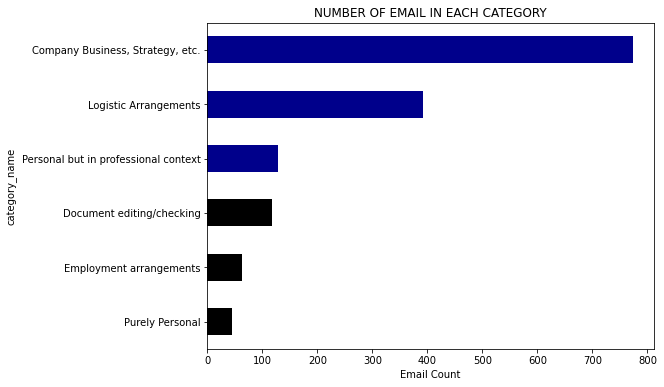

In [16]:
#plot count horizontal map
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
colors = ['black','black','black','darkblue','darkblue','darkblue']
email_dataframe.groupby('category_name').email_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF EMAIL IN EACH CATEGORY')
plt.xlabel('Email Count', fontsize = 10)

In [17]:
email_dataframe.groupby('category_name').email_text.count().sort_values()/email_dataframe.groupby('category_name').email_text.count().sum()

category_name
Purely Personal                         0.029005
Employment arrangements                 0.040870
Document editing/checking               0.077785
Personal but in professional context    0.084377
Logistic Arrangements                   0.258405
Company Business, Strategy, etc.        0.509558
Name: email_text, dtype: float64

# TEXT PROCESSING

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection

In [19]:
# Transform email_text to vector
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2))
features = tfidf.fit_transform(email_dataframe.email_text)
print(features.shape)
labels = email_dataframe.category_tag
set(labels)

(1517, 14057)


{0, 1, 2, 3, 4, 5}

In [20]:
from sklearn.feature_selection import SelectKBest, chi2
sb_ch2 = SelectKBest(chi2, k=6000)
features = sb_ch2.fit_transform(features, labels)

In [21]:
feature_name = np.array(tfidf.get_feature_names())[sb_ch2.get_support(indices=True)]

C:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# Finding the three most correlated terms with each of the product categories
from sklearn.feature_selection import chi2
N = 10
indices_list = np.array([], dtype=int)
for email_category, category_tag in sorted(category_name_to_tag.items()):
    features_chi2 = chi2(features, labels == category_tag-1)
    indices = np.argsort(features_chi2[0])
    indices_list = np.append(indices_list, indices[-N:])
    feature_names = feature_name[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(f"Email category : {email_category},{category_tag}")
    print(f"Most Correlated Unigrams are: {', '.join(unigrams[-N:])}")
    print(f"Most Correlated Bigrams are: {', '.join(bigrams[-N:])}")
    print(f"\n\n")
features = features.toarray()

Email category : Company Business, Strategy, etc.,1
Most Correlated Unigrams are: said, price, market, power, prices, vince, resume, california, ferc, meeting
Most Correlated Bigrams are: xxxx million, vince original, segner staff, expense document, concur expense, xxxx dining, dining room, ed segner, staff meeting, meeting xxxx



Email category : Document editing/checking,6
Most Correlated Unigrams are: appeal, letter, release, aa, paragraph, memo, comments, changes, looks, draft
Most Correlated Bigrams are: mark xxxxx, paula xxxxx, focus groups, confidential agreement, presentation looks, xxxx revised, draft letter, attached draft, looks fine, looks good



Email category : Employment arrangements,5
Most Correlated Unigrams are: compensation, handled, barry, lift, candidate, description, promotion, multi, job, resume
Most Correlated Bigrams are: xxxx interview, would pleased, what next, prc process, interview enron, natural resources, washington office, year end, telephone interview

# Evaluating Multiple-models

In [23]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [24]:
models = [
    GaussianNB(), MultinomialNB(),
    RandomForestClassifier(n_estimators=100, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(random_state=0),
#     AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5, random_state= 0),
#     MLPClassifier(hidden_layer_sizes=(10,)),
]

In [25]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [26]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='balanced_accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print('Done')
cv_df_balanced = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'balanced_accuracy'])
mean_accuracy = cv_df_balanced.groupby('model_name').balanced_accuracy.mean()
std_accuracy = cv_df_balanced.groupby('model_name').balanced_accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Balanced Accuracy', 'Standard deviation']
acc

Done
Done
Done
Done
Done
Done


,Mean Balanced Accuracy,Standard deviation
model_name,,
DecisionTreeClassifier,0.324777,0.046545
GaussianNB,0.244234,0.061245
LinearSVC,0.361135,0.048673
LogisticRegression,0.273887,0.019548
MultinomialNB,0.224635,0.020978
RandomForestClassifier,0.288162,0.061513


In [27]:
acc.to_clipboard()

In [28]:
cv_df_balanced

,model_name,fold_idx,balanced_accuracy
0,GaussianNB,0,0.237569
1,GaussianNB,1,0.314707
2,GaussianNB,2,0.185424
3,GaussianNB,3,0.184630
4,GaussianNB,4,0.298840
5,MultinomialNB,0,0.233061
6,MultinomialNB,1,0.244685
7,MultinomialNB,2,0.191205
8,MultinomialNB,3,0.218235
9,MultinomialNB,4,0.235986


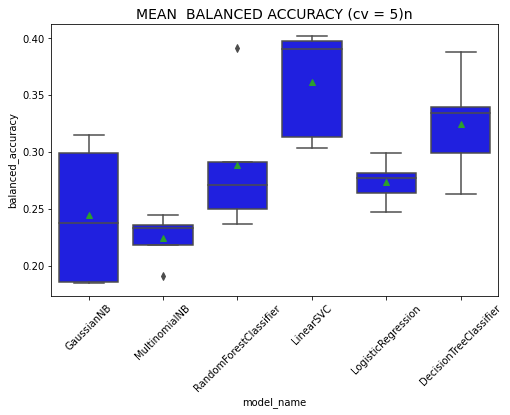

In [29]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='balanced_accuracy', 
            data=cv_df_balanced, 
            color='blue', 
            showmeans=True)
plt.title("MEAN  BALANCED ACCURACY (cv = 5)n", size=14)
plt.xticks(rotation=45);

In [30]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print('Done')
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Done
Done
Done
Done
Done
Done


,Mean Accuracy,Standard deviation
model_name,,
DecisionTreeClassifier,0.516730,0.063396
GaussianNB,0.501563,0.063747
LinearSVC,0.614298,0.058750
LogisticRegression,0.620230,0.053788
MultinomialNB,0.577401,0.038470
RandomForestClassifier,0.592540,0.058614


In [31]:
cv_df

,model_name,fold_idx,accuracy
0,GaussianNB,0,0.572368
1,GaussianNB,1,0.559211
2,GaussianNB,2,0.462046
3,GaussianNB,3,0.422442
4,GaussianNB,4,0.491749
5,MultinomialNB,0,0.608553
6,MultinomialNB,1,0.628289
7,MultinomialNB,2,0.541254
8,MultinomialNB,3,0.554455
9,MultinomialNB,4,0.554455


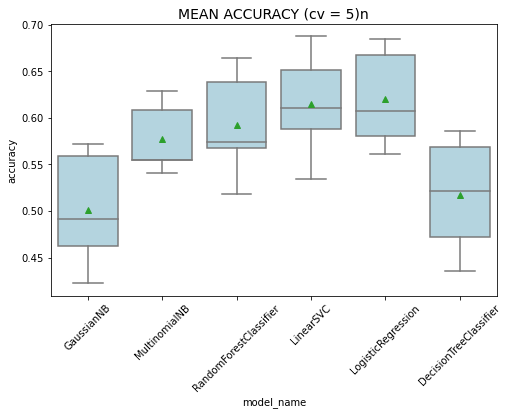

In [32]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14)
plt.xticks(rotation=45);

# Training and evaluating LinearSVC

LinearSVC model is performing better that other models if we compare balanced accuracy. We will train LinearSVC

In [33]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               email_dataframe.index, test_size=0.2, 
                                                               random_state=42, stratify=email_dataframe.category_tag.values)

In [34]:
# Due to class imbalance training weight balanced model
model = LinearSVC(class_weight='balanced', dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [35]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=[category_tag_to_name[i] for i in sorted(category_tag_to_name.keys())]))

				CLASSIFICATIION METRICS

                                      precision    recall  f1-score   support

    Company Business, Strategy, etc.       0.73      0.82      0.77       155
                     Purely Personal       1.00      0.33      0.50         9
Personal but in professional context       0.45      0.35      0.39        26
               Logistic Arrangements       0.66      0.65      0.66        78
             Employment arrangements       0.38      0.25      0.30        12
           Document editing/checking       0.43      0.42      0.43        24

                            accuracy                           0.67       304
                           macro avg       0.61      0.47      0.51       304
                        weighted avg       0.66      0.67      0.66       304



In [36]:
sklearn.metrics.balanced_accuracy_score(y_test, y_pred, adjusted=True)

0.36387096774193534

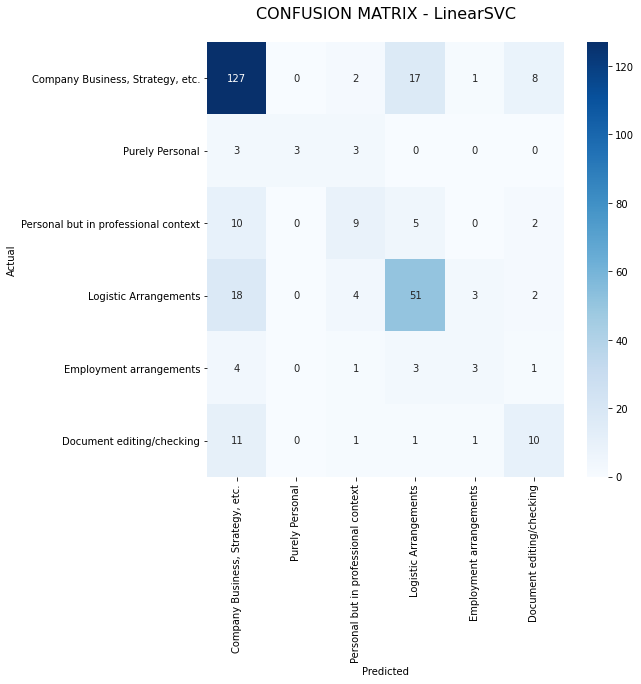

In [37]:
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[category_tag_to_name[i] for i in sorted(category_tag_to_name.keys())], 
            yticklabels=[category_tag_to_name[i] for i in sorted(category_tag_to_name.keys())])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

From above we can see due to imbalanced dataset more datapoint from other class get classified as "Company Business, Strategy, etc"
This class constitute 50% of dataset and data for other class is very low

# Training and evalating fine-tuned bert model

We will now fine-tune pretrained BERT to see if performance increases.
<br>
Training repo
<br>
https://github.com/Navneet3440/enron_email_classifier
<br>
Training done on google colab
<br>
https://colab.research.google.com/drive/1hC4VkRWOrtnFGGRCAZCQYzT1jEYD7ujI?usp=sharing
<br>
Data used is slightly different----I have not removed stop word as it is not required
<br>
Trained model location and corresponding csv file which contain train and validation loss
<br>
https://drive.google.com/drive/folders/1T0owuwvJbncAkiqyZAmVDF3-uJ7sYkKx?usp=sharing

In [38]:
result_csv = './bert-base-uncased_512_ds1_ba_lr3e-05_3_best_balance_accuracy_forward_removed_2.csv'
result_df = pd.read_csv(result_csv)

In [39]:
result_df

,epoc,train_loss,valid_loss,valic_accuracy,valid_balanced_accuracy,valid_balanced_accuracy_adjusted
0,1,1.673819,1.343389,0.651466,0.523860,0.428632
1,2,1.148633,1.120136,0.684039,0.536538,0.443846
2,3,0.686389,1.258390,0.664495,0.519996,0.423996
3,4,0.402887,1.122326,0.674267,0.634847,0.561816
4,5,0.192231,1.313011,0.648208,0.586378,0.503654
5,6,0.105181,1.496654,0.690554,0.554594,0.465513
6,7,0.065014,1.607927,0.710098,0.563782,0.476538
7,8,0.048428,1.632972,0.723127,0.573397,0.488077
8,9,0.040954,1.719950,0.713355,0.576549,0.491859
9,10,0.032074,1.631847,0.719870,0.578686,0.494423


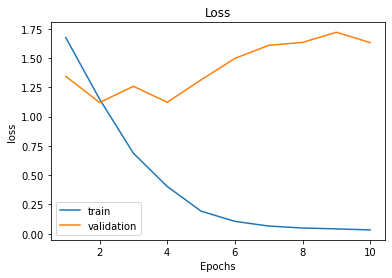

In [40]:
plt.title("Loss")
plt.plot(result_df.epoc.values,result_df.train_loss.values, label='train')
plt.plot(result_df.epoc.values,result_df.valid_loss.values, label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

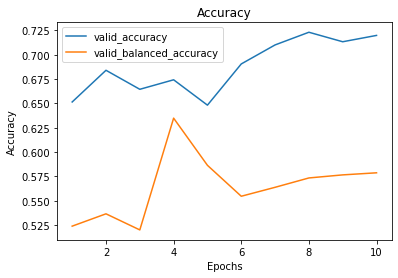

In [41]:
plt.title("Accuracy")
plt.plot(result_df.epoc.values,result_df.valic_accuracy.values, label='valid_accuracy')
plt.plot(result_df.epoc.values,result_df.valid_balanced_accuracy.values, label='valid_balanced_accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As we can see after epoch 4 models start to overfit. So we will use model check-point at 4rd epoch
balanced accuracy is much higher compared to LinearSVC

In [42]:
# getting file id for files which was used in test case of LinearSVM
test_file_id_svm = email_dataframe['file_id'][indices_test].values

In [43]:
# Reprocessing files. Only not removing stop word
test_bert_df = pd.read_csv('./test_bert_inference.csv')

In [44]:
bert_pred_csv = pd.read_csv('./bert_inference.csv')

In [45]:
y_test, y_pred = test_bert_df.category_tag -1 , bert_pred_csv.model_category_label

In [46]:
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=[category_tag_to_name[i] for i in sorted(category_tag_to_name.keys())]))

                                      precision    recall  f1-score   support

    Company Business, Strategy, etc.       0.81      0.73      0.77       156
                     Purely Personal       0.50      0.56      0.53         9
Personal but in professional context       0.27      0.58      0.37        26
               Logistic Arrangements       0.79      0.61      0.69        80
             Employment arrangements       0.53      0.67      0.59        12
           Document editing/checking       0.67      0.67      0.67        24

                            accuracy                           0.67       307
                           macro avg       0.60      0.63      0.60       307
                        weighted avg       0.73      0.67      0.69       307



In [47]:
sklearn.metrics.balanced_accuracy_score(y_test, y_pred, adjusted=True)

0.5618162393162393

In [48]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.6742671009771987

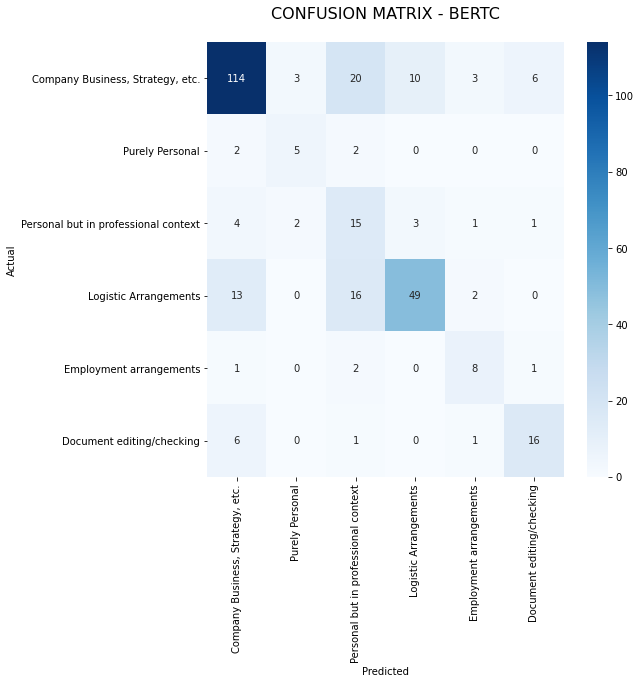

In [49]:
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[category_tag_to_name[i] for i in sorted(category_tag_to_name.keys())], 
            yticklabels=[category_tag_to_name[i] for i in sorted(category_tag_to_name.keys())])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - BERTC\n", size=16);

We can observe that fine-tuned bert model performs better than LinearSVC for classes with less data-point